In [125]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df1=df.reset_index()['Close']

In [127]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [128]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [111]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [129]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [130]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [132]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [133]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 128ms/step - loss: 0.0362 - val_loss: 0.0116
Epoch 2/100
16/16 [==============================] - 1s 68ms/step - loss: 0.0075 - val_loss: 0.0290
Epoch 3/100
16/16 [==============================] - 2s 132ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/100
16/16 [==============================] - 2s 114ms/step - loss: 3.4027e-04 - val_loss: 0.0011
Epoch 5/100
16/16 [==============================] - 1s 69ms/step - loss: 2.4680e-04 - val_loss: 9.5646e-04
Epoch 6/100
16/16 [==============================] - 1s 67ms/step - loss: 2.1048e-04 - val_loss: 8.9684e-04
Epoch 7/100
16/16 [==============================] - 1s 68ms/step - loss: 2.0692e-04 - val_loss: 8.9711e-04
Epoch 8/100
16/16 [==============================] - 1s 83ms/step - loss: 1.9941e-04 - val_loss: 8.8266e-04
Epoch 9/100
16/16 [==============================] - 2s 109ms/step - loss: 1.9703e-04 - val_loss: 8.3684e-04
Epoch 10/100
16/16 [==============================] 

In [134]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 18ms/step


In [135]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [136]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 155.23904894698117
Testing RMSE: 157.9594182969741


In [137]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.88306004]
101
1 day input [0.75477932 0.76118431 0.74641359 0.70255877 0.68955262 0.67556615
 0.6751087  0.69569623 0.67465115 0.67223296 0.66027256 0.63419499
 0.65752756 0.65961894 0.62785532 0.63628642 0.62752851 0.65759288
 0.66105681 0.66484755 0.68288624 0.68236337 0.69118655 0.69889877
 0.69412771 0.69451984 0.71151269 0.73268851 0.74196924 0.73759031
 0.75131539 0.76419069 0.74504104 0.75347209 0.76092283 0.79615053
 0.82020198 0.80209797 0.8211823  0.80333978 0.79647724 0.79739224
 0.8159538  0.81170551 0.82562666 0.8150388  0.80745732 0.78085684
 0.78366725 0.7868697  0.76928866 0.77719684 0.77386365 0.76013857
 0.76406005 0.79752298 0.81582305 0.80124839 0.80954871 0.79464724
 0.78098758 0.79386298 0.80771871 0.81033306 0.82902527 0.82346985
 0.83915557 0.85144279 0.84196599 0.84915524 0.85778246 0.84490705
 0.84078951 0.86118107 0.87157286 0.88817358 0.89647399 0.89294474
 0.88072285 0.88660507 0.86941606 0.86137713 0.85680214 0.89248719
 0.89019974 0.89033039 0.89843473

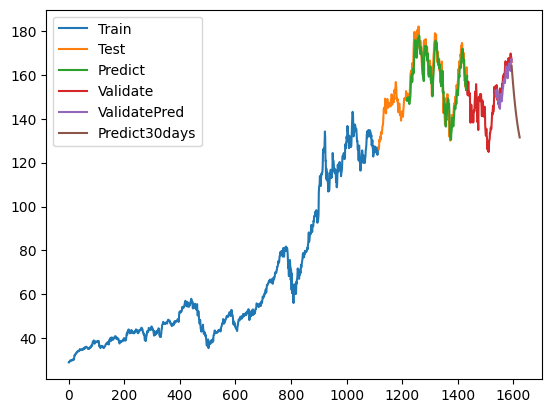

In [138]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()